In [5]:
using CSV,DataFrames,Plots,Statistics,Dates

# Main definitions

In [6]:
# tweetID_to_date(tid)
#  Convert tweet ID (usually Int64) to a UTC date

function tweetID_to_date(tid)
    offset = 1288834974657
    tstamp = (tid >> 22) + offset
    Dates.unix2datetime(floor(tstamp/1000))
end

tweetID_to_date (generic function with 1 method)

This is the function that does time-averaging of sentiment. It uses a trapezoid rule approximation of an integral against a quadratically decreasing waight function. If there are large jumps in the times of the tweets (significant fraction of the window size), this can cause overweighting of a few values and violate the bounds of the original data.

In [10]:
# decayavg(t,delta,time,value)
#  Perform a decaying average of sentiment data over the window (t-delta,t). Returns NaN if there are no values in the time window.

function decayavg(t::DateTime,delta::Dates.Period,time::AbstractVector,value::AbstractVector)
    idx = t-delta .< time .< t
    isempty(idx) && return NaN
    s = value[idx];
    x = @. (t - time[idx]) / convert(Millisecond,delta)  # variable of integration
    w = @. 1/(1+16x^2) * 4/atan(4);    # weighting
    q = s.*w;    # integrand
    dx = -diff(x);
    sum( dx.*(q[1:end-1]+q[2:end])/2  )    # nonequispaced trapezoid rule 
end

# Vectorized version for convenience
decayavg(t::AbstractVector{DateTime},args...) = [ decayavg(t,args...) for t in t ]

decayavg (generic function with 2 methods)

# Demo for fake data

In [11]:
tweet = CSV.read("faketweetsbig.csv");

Here is a plot comparing the effects of averaging over time windows of varying duration.

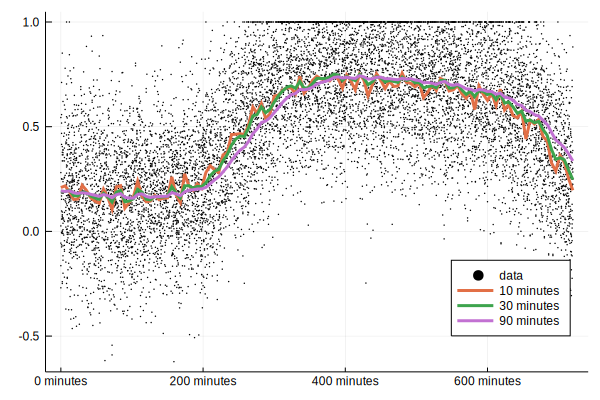

In [13]:
tstart = DateTime(2020,4,1);
tspan = [ Minute(n) for n in 0:6:12*60 ];  # every 6 minutes over half day

idx = tspan[1] .≤ tweet.time.-tstart .≤ tspan[end];
t = tweet.time[idx] .- tstart;
t = round.(t,Minute(1));
plt = scatter(t,tweet.sentiment[idx],m=(1,nothing),label="data",leg=:bottomright)

t = tstart .+ tspan;
plot!(tspan,decayavg(t,Minute(10),tweet.time,tweet.sentiment),l=3,label="10 minutes")
plot!(tspan,decayavg(t,Minute(30),tweet.time,tweet.sentiment),l=3,label="30 minutes")
plot!(tspan,decayavg(t,Minute(90),tweet.time,tweet.sentiment),l=3,label="90 minutes")


# Cornoa tweets from IEEE

In [14]:
# typically 12-24 hours per file
tweet = CSV.read("data/corona_tweets_04.csv");
size(tweet)

(1233340, 2)

Screen out all tweets with zero sentiment. (Images?)

In [15]:
tweet = filter(x -> !iszero(x[:sentiment]),tweet)
size(tweet)

(756475, 2)

In [17]:
tweet.time = tweetID_to_date.(tweet.tweet_id);
tstart,tend = tweet.time[[1,end]]

2-element Array{DateTime,1}:
 2020-03-21T03:42:53
 2020-03-22T02:01:32

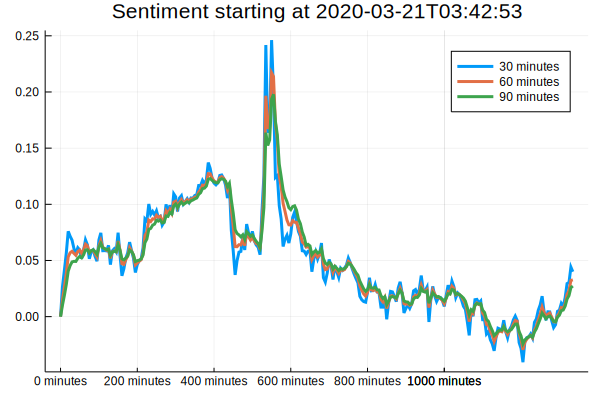

In [20]:
tspan = tstart:Minute(5):tend
dt = convert.(Minute,tspan.-tstart)

plt = plot(dt,decayavg(tspan,Minute(30),tweet.time,tweet.sentiment),l=3,label="30 minutes")
plot!(dt,decayavg(tspan,Minute(60),tweet.time,tweet.sentiment),l=3,label="60 minutes")
plot!(dt,decayavg(tspan,Minute(90),tweet.time,tweet.sentiment),l=3,label="90 minutes")
title!("Sentiment starting at $tstart")

In [21]:
savefig(plt,"$tstart.png")

# Ben's DTM data

In [22]:
tweet = CSV.read("data/DTMbyTweet.csv")

# convert date strings to DateTime
ti = [ DateTime(s[1:end-1]) for s in tweet.fulltime ]
tweet.time = ti;

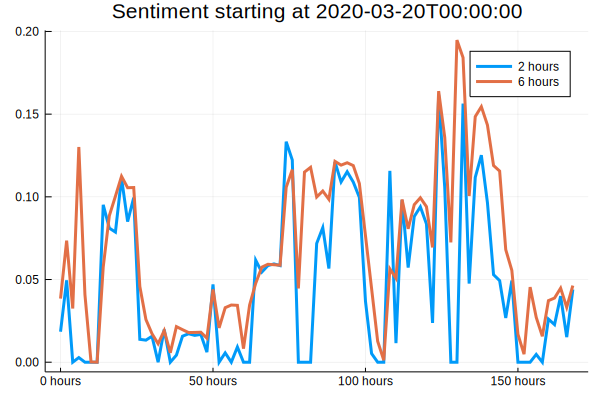

In [23]:
tstart = DateTime(2020,3,20)
tspan = tstart:Hour(2):tstart+Day(7)
dt = convert.(Hour,tspan.-tstart)

plt = plot(dt,decayavg(tspan,Hour(2),tweet.time,tweet.sentiment),l=3,label="2 hours")
plot!(dt,decayavg(tspan,Hour(6),tweet.time,tweet.sentiment),l=3,label="6 hours")
title!("Sentiment starting at $tstart")

In [24]:
savefig(plt,"Ben-$tstart.png")